This notebook willl come in 2 parts. The first, I will detail my experimentation in 1-D with using pymix to fit to the posterior distribution of my fit. After that, I'll try to use it to use pymix to fit to a 2-D image. 

--update. I'll probably get to the 2-D but this notebook is just the 1-D. 

###1-D MOG with PyMix
Below, I plot a histogram of one of my samples from my fitting program. As you probablyrecall, one of the problems I'm having is that both gaussians are fitting to multiple peaks, rather than each converging to their own. In emcee's eyes, all the gaussians are created equal so they are interchangeable. Therefore, for simplicity's sake I've been doing calculations on both distributions, combined.

In [5]:
#Make sure to change this to whatever it is on your machine.
filename = '/home/jeffrey/Bayesian_Image_Modeling/Fit_Many_Images/Samples/CFHTLS_047_0155_g'

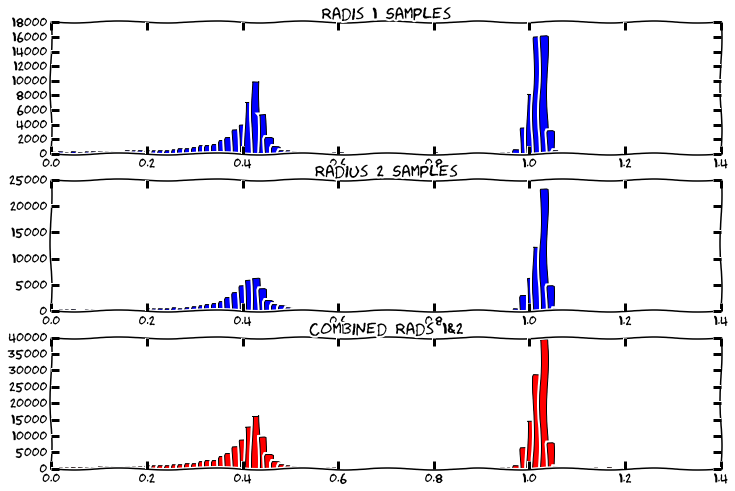

In [6]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12,8)
plt.xkcd()
samples = np.loadtxt(filename, delimiter = ',')
samples_amps = samples[:, :2].reshape((-1))
samples_rads = samples[:, 2:].reshape((-1))
_range = (0, 1.4)
plt.subplot(311)
plt.hist(samples[:,2], bins = 100, range = _range)
plt.title('Radis 1 Samples')
plt.subplot(312)
plt.hist(samples[:,3], bins = 100, range = _range)
plt.title('Radius 2 Samples')
plt.subplot(313)
plt.hist(samples_rads, bins = 100, color = 'r', range = _range)
plt.title('Combined Rads 1&2')
plt.show()

In the past, what I'd do was either select the mean or mode. Since I need to select 2 amplitudes from the distribution, a mean is out. I can choose the most and second most popular results, but this has it's own problems. It's clear from looking at the distribution what the 2 peaks should be (1.6 and ~1.75) but getting the computer to see that is tricky.

/home/jeffrey/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/home/jeffrey/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


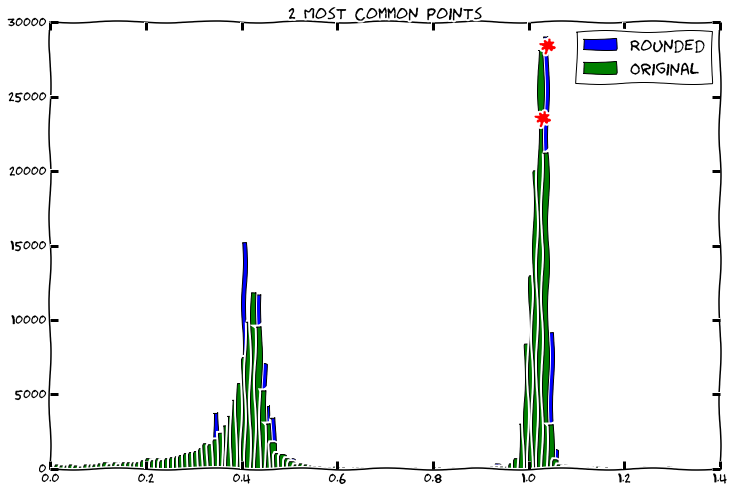

In [7]:
#Counter objects are dictionaries that have objects in a list as keys
#and the number of occurences as vals.
from collections import Counter

#the rounding allows for binning. 
dec = 2
round_rads = np.round(samples_rads, decimals = dec).tolist()
amp_counter = Counter(round_rads)
#pull 2 most common points
calc_as, a_counts = zip(*amp_counter.most_common(2))
#stuff for plotting the points we picked
nBins = (_range[1]-_range[0])*10**dec
plt.hist(round_rads,bins = nBins, range = _range, label = 'Rounded')
plt.hist(samples_rads, bins = nBins, range = _range, color = 'g', label = 'Original')
plt.title('2 Most Common points')

for amp, count in zip(calc_as, a_counts):
    plt.text(amp-.01, count-1000, '*', fontsize = '35', color = 'r' )

plt.legend()
plt.show()

There's quite a few ways this approach is obviously flawed. For starters, the rounding necesary for binning introduces changes in the data, and the points selected are in fact not the most common in the original. Also, the major error is that 2 points from the same peak are selected. This clearly will not do. 

I chose to try to use the pymix module to fit a MOG to the distribution. I do so below.

In [8]:
import mixture
from scipy.stats import mode
nGauss = 2 #number of peaks in our distribution
calc_as = []

data = mixture.DataSet()
data.fromArray(samples_rads)#pass in the data to the object

#now, I have to provide an initial estimate to the EM.

sortSamples = np.round(np.sort(samples_rads), decimals = dec)
lenOverN = sortSamples.shape[0]/float(nGauss)
#slice the sorted samples into nGauss chunks. Take the mean(mode in this case) and std of each as a first guess.
mus = [mode(sortSamples[(n*lenOverN):((n+1)*lenOverN)])[0][0] for n in xrange(nGauss)]
sigs = [sortSamples[n*lenOverN:(n+1)*lenOverN].std() for n in xrange(nGauss)]

gaussians = [mixture.NormalDistribution(mu, sig) for mu,sig in zip(mus, sigs)]

#number of parameters, the weight of each (uniform) and the parameters
model = mixture.MixtureModel(nGauss, [1./nGauss for n in xrange(nGauss)],gaussians)

#the devs for pymix, in their wisdom, set a minimum standard deviation of .1
#not gonna work. Why would that be a good idea?
for g in model.components:
    g.distList[0].min_sigma = .001
   
#do either 500 iterations or until less than .001 difference, whichever first.
model.EM(data, 500, .000001)
print model

calc_rads = []
calc_rads_sigs = []

#there's no easy way to extract the params that I can find. Maybe I'm dumb.
#found this in the source code
for g in model.components:
    calc_rads.append(g.distList[0].mu)
    calc_rads_sigs.append(g.distList[0].sigma)
    
plt.hist(samples_rads, bins = nBins, range=_range)
for n in xrange(nGauss):
    plt.vlines([calc_rads[n]+x*calc_rads_sigs[n] for x in (-1,0,1)], 0, 50000, colors = ['r','g','r'])
    plt.text(calc_rads[n], 55000, '%d'%(n+1), fontsize = '30')
    
plt.show()

ImportError: No module named mixture

Interesting, but let's compare to the estimates I made initially. Those are shown in purple. 

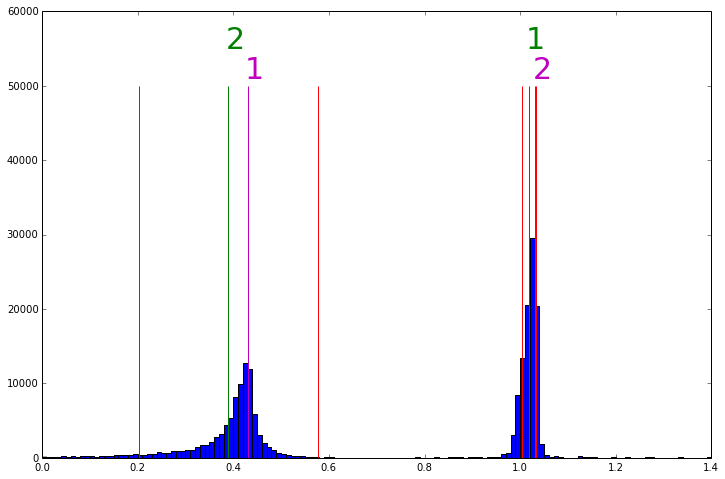

In [5]:
plt.hist(samples_rads, bins = nBins, range=_range)
for n in xrange(nGauss):
    plt.vlines([calc_rads[n]+x*calc_rads_sigs[n] for x in (-1,0,1)], 0, 50000, colors = ['r','g','r'])
    plt.text(calc_rads[n], 55000, '%d'%(n+1), fontsize = '30', color = 'g')
    plt.text(mus[n], 51000, '%d'%(n+1), fontsize = '30',color = 'm' )
plt.vlines(mus, 0, 50000, colors = ['m'])
    
plt.show()

For whatever reason, the EM does not fit very well, even when given pretty much the exact center. Right now my code just uses the estimate, rather than the result of the fit. 